In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Data Initializing**

In [ ]:
import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/skripsi_chandra/ABSA_performance.csv')
df.head()

,review_token,Performance and Stability
0,"[7, 36, 62, 27, 269, 26, 6, 97, 334, 7, 288, 2...",0
1,"[293, 74, 1, 913, 107, 80, 4, 19, 186, 15, 198...",0
2,"[2, 87, 17, 107, 137, 213, 89, 2, 82, 6, 53, 3...",0
3,"[328, 32, 186, 329, 820, 1178, 2402, 326, 2403...",0
4,"[2, 14, 12, 33, 519, 41, 4, 50, 25, 19, 68, 68...",1


In [ ]:
print(type(df['Performance and Stability'][0]))
print(type(df['review_token'][0]))

<class 'numpy.int64'>
<class 'str'>


In [ ]:
df['review_token'] = df['review_token'].map(lambda x: list(map(int, x[1:-1].split(', '))))

In [ ]:
print(type(df['Performance and Stability'][0]))
print(type(df['review_token'][0]))

<class 'numpy.int64'>
<class 'list'>


In [ ]:
reviews = df[['review_token']]
labels = df['Performance and Stability']

## **Splitting Data and Applying Padding**

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(reviews, labels, test_size=0.3, random_state=42, stratify=labels)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

(2538, 1) (544, 1) (544, 1) (2538,) (544,) (544,)


In [ ]:
x_train_pad = x_train['review_token']
x_val_pad = x_val['review_token']
x_test_pad = x_test['review_token']

In [ ]:
from keras.preprocessing import sequence
from keras.utils import pad_sequences

x_train = pad_sequences(x_train_pad, maxlen=100)
x_val = pad_sequences(x_val_pad, maxlen=100)
x_test = pad_sequences(x_test_pad, maxlen=100)

## **Modeling Initialization**

In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
import numpy as np

embedding_matrix = np.load('/content/gdrive/MyDrive/skripsi_chandra/embedding_matrix.npy')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(restore_best_weights=True, patience=3,
                               min_delta=0.01, monitor='val_loss')

**Hyperparameter tuning**
1. Filter Size [2], [2,3,4]
3. Dropout Rate [0.25, 0.5]
4. Learning Rate [0.001, 0.0001]

## **CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, Activation, MaxPooling1D, Flatten, Embedding
from tensorflow.keras import optimizers, regularizers

def build_CNN(hp):
  model = Sequential()
  model.add(Embedding(input_dim=2500, output_dim=300,
                      weights=[embedding_matrix], input_length=100))

  filter_sizes = hp.Choice('filter size', values=['2', '2,3,4'])
  filter_sizes_list = [int(x) for x in filter_sizes.split(',')]
  dropout_rate = hp.Choice('dropout rate', values=[0.25, 0.5])
  learn_rate = hp.Choice('learning rate', values=[0.001, 0.0001])

  conv_layers = []
  for filter_size in filter_sizes_list:
    conv_layer = Conv1D(filters=200, kernel_size=filter_size,
                        padding='valid', activation='relu', strides=1)
    conv_layers.append(conv_layer)

  for conv_layer in conv_layers:
    model.add(conv_layer)

  model.add(MaxPooling1D())
  model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(dropout_rate))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizers.Adam(learning_rate=learn_rate), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
from keras_tuner import GridSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner = GridSearch(
    build_CNN,
    objective='val_accuracy',
    directory='performance_CNN',
    project_name='performance'
)

tuner.search(x_train, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val,y_val), callbacks=[early_stopping])
tuner.results_summary()

Trial 8 Complete [00h 00m 30s]
val_accuracy: 0.9485294222831726

Best val_accuracy So Far: 0.9595588445663452
Total elapsed time: 00h 03m 39s
Results summary
Results in performance_CNN/performance
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0004 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.25
learning rate: 0.001
Score: 0.9595588445663452

Trial 0001 summary
Hyperparameters:
filter size: 2
dropout rate: 0.25
learning rate: 0.0001
Score: 0.9577205777168274

Trial 0000 summary
Hyperparameters:
filter size: 2
dropout rate: 0.25
learning rate: 0.001
Score: 0.9522058963775635

Trial 0002 summary
Hyperparameters:
filter size: 2
dropout rate: 0.5
learning rate: 0.001
Score: 0.9522058963775635

Trial 0006 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.5
learning rate: 0.001
Score: 0.9522058963775635

Trial 0003 summary
Hyperparameters:
filter size: 2
dropout rate: 0.5
learning rate: 0.0001
Score: 0.9503676295280457

Trial 0005 summa

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp.values

{'filter size': '2,3,4', 'dropout rate': 0.25, 'learning rate': 0.001}

In [ ]:
model = build_CNN(best_hp)
history = model.fit(x_train, y_train,
                    epochs=50, batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])
model.summary()

Epoch 1/50
40/40 [==============================] - 7s 122ms/step - loss: 1.3775 - accuracy: 0.9259 - val_loss: 0.9029 - val_accuracy: 0.9283
Epoch 2/50
40/40 [==============================] - 3s 75ms/step - loss: 0.6234 - accuracy: 0.9279 - val_loss: 0.4389 - val_accuracy: 0.9283
Epoch 3/50
40/40 [==============================] - 2s 55ms/step - loss: 0.3000 - accuracy: 0.9460 - val_loss: 0.2773 - val_accuracy: 0.9449
Epoch 4/50
40/40 [==============================] - 2s 43ms/step - loss: 0.1471 - accuracy: 0.9748 - val_loss: 0.2519 - val_accuracy: 0.9540
Epoch 5/50
40/40 [==============================] - 2s 43ms/step - loss: 0.0724 - accuracy: 0.9890 - val_loss: 0.1986 - val_accuracy: 0.9540
Epoch 6/50
40/40 [==============================] - 1s 25ms/step - loss: 0.0397 - accuracy: 0.9921 - val_loss: 0.2424 - val_accuracy: 0.9485
Epoch 7/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0313 - accuracy: 0.9941 - val_loss: 0.2563 - val_accuracy: 0.9559
Epoch 8/50
4

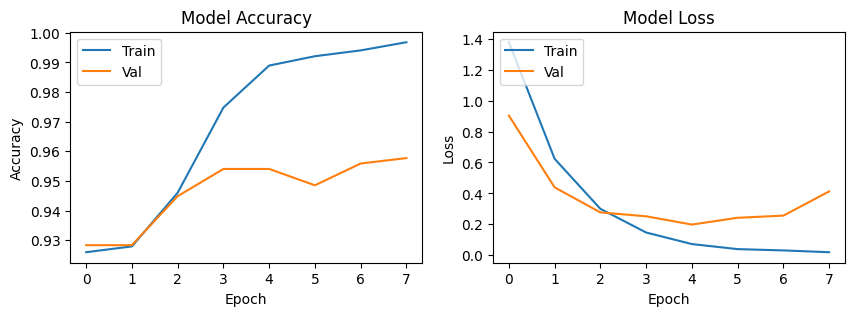

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Val')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Val')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')

plt.show()

In [ ]:
model.save('performance_CNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions = model.predict(x_test)

17/17 [==============================] - 0s 2ms/step


In [ ]:
y_pred = predictions >= 0.5

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f'Macro-Average Precision: {macro_precision}')
print(f'Macro-Average Recall: {macro_recall}')
print(f'Macro-Average F1 Score: {macro_f1}')

Macro-Average Precision: 0.7645832323134365
Macro-Average Recall: 0.7770500126935771
Macro-Average F1 Score: 0.7706349206349206


In [ ]:
from sklearn.metrics import classification_report

labels = ['Negative', 'Positive']
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       505
           1       0.56      0.59      0.57        39

    accuracy                           0.94       544
   macro avg       0.76      0.78      0.77       544
weighted avg       0.94      0.94      0.94       544



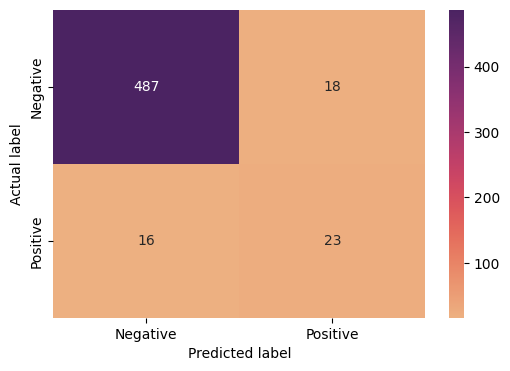

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='flare', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()

# **CNN-LSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Dropout, Activation, MaxPooling1D, Embedding
from tensorflow.keras import optimizers, regularizers

def build_CNNLSTM(hp):
  model = Sequential()
  model.add(Embedding(input_dim=2500, output_dim=300,
                      weights=[embedding_matrix], input_length=100))

  filter_sizes = hp.Choice('filter size', values=['2', '2,3,4'])
  filter_sizes_list = [int(x) for x in filter_sizes.split(',')]
  dropout_rate = hp.Choice('dropout rate', values=[0.25, 0.5])
  learn_rate = hp.Choice('learning rate', values=[0.001, 0.0001])

  conv_layers = []
  for filter_size in filter_sizes_list:
    conv_layer = Conv1D(filters=200, kernel_size=filter_size,
                        padding='valid', activation='relu', strides=1)
    conv_layers.append(conv_layer)

  for conv_layer in conv_layers:
    model.add(conv_layer)

  model.add(MaxPooling1D())
  model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(64))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizers.Adam(learning_rate=learn_rate), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
from keras_tuner import GridSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner = GridSearch(
    build_CNNLSTM,
    objective='val_accuracy',
    directory='performance_CNNLSTM',
    project_name='performance'
)

tuner.search(x_train, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val,y_val), callbacks=[early_stopping])
tuner.results_summary()

Trial 8 Complete [00h 00m 51s]
val_accuracy: 0.9595588445663452

Best val_accuracy So Far: 0.9632353186607361
Total elapsed time: 00h 05m 02s
Results summary
Results in performance_CNNLSTM/performance
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0003 summary
Hyperparameters:
filter size: 2
dropout rate: 0.5
learning rate: 0.0001
Score: 0.9632353186607361

Trial 0000 summary
Hyperparameters:
filter size: 2
dropout rate: 0.25
learning rate: 0.001
Score: 0.9613970518112183

Trial 0001 summary
Hyperparameters:
filter size: 2
dropout rate: 0.25
learning rate: 0.0001
Score: 0.9613970518112183

Trial 0005 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.25
learning rate: 0.0001
Score: 0.9613970518112183

Trial 0007 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.5
learning rate: 0.0001
Score: 0.9595588445663452

Trial 0002 summary
Hyperparameters:
filter size: 2
dropout rate: 0.5
learning rate: 0.001
Score: 0.9540441036224365

Trial 0004

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp.values

{'filter size': '2', 'dropout rate': 0.5, 'learning rate': 0.0001}

In [ ]:
# Training and Validation
model = build_CNNLSTM(best_hp)
history = model.fit(x_train, y_train,
                    epochs=50, batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])
model.summary()

Epoch 1/50
40/40 [==============================] - 9s 160ms/step - loss: 2.0881 - accuracy: 0.8952 - val_loss: 1.8739 - val_accuracy: 0.9283
Epoch 2/50
40/40 [==============================] - 3s 80ms/step - loss: 1.7107 - accuracy: 0.9283 - val_loss: 1.5998 - val_accuracy: 0.9283
Epoch 3/50
40/40 [==============================] - 3s 66ms/step - loss: 1.5343 - accuracy: 0.9283 - val_loss: 1.4809 - val_accuracy: 0.9283
Epoch 4/50
40/40 [==============================] - 2s 58ms/step - loss: 1.4210 - accuracy: 0.9283 - val_loss: 1.3727 - val_accuracy: 0.9283
Epoch 5/50
40/40 [==============================] - 2s 45ms/step - loss: 1.3139 - accuracy: 0.9283 - val_loss: 1.2713 - val_accuracy: 0.9283
Epoch 6/50
40/40 [==============================] - 1s 37ms/step - loss: 1.2135 - accuracy: 0.9283 - val_loss: 1.1750 - val_accuracy: 0.9283
Epoch 7/50
40/40 [==============================] - 1s 30ms/step - loss: 1.1173 - accuracy: 0.9283 - val_loss: 1.0804 - val_accuracy: 0.9283
Epoch 8/50
4

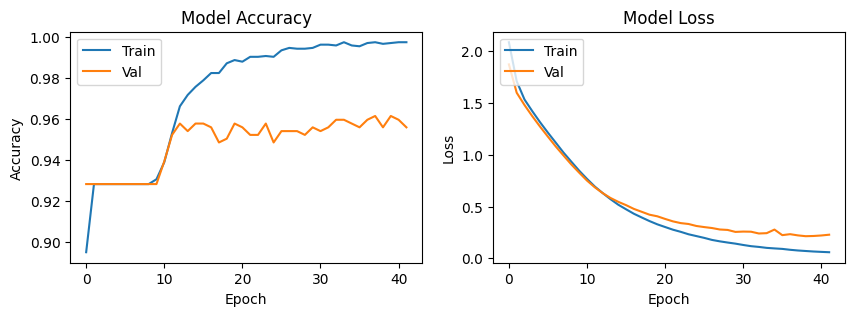

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Val')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Val')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')

plt.show()

In [ ]:
model.save('performance_CNNLSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions = model.predict(x_test)

17/17 [==============================] - 0s 3ms/step


In [ ]:
y_pred = predictions >= 0.5

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Macro-Average Precision: {macro_precision}")
print(f"Macro-Average Recall: {macro_recall}")
print(f"Macro-Average F1 Score: {macro_f1}")

Macro-Average Precision: 0.7814300680984809
Macro-Average Recall: 0.8273419649657273
Macro-Average F1 Score: 0.8021934197407776


In [ ]:
from sklearn.metrics import classification_report

labels = ["Negative", "Positive"]
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       505
           1       0.59      0.69      0.64        39

    accuracy                           0.94       544
   macro avg       0.78      0.83      0.80       544
weighted avg       0.95      0.94      0.95       544



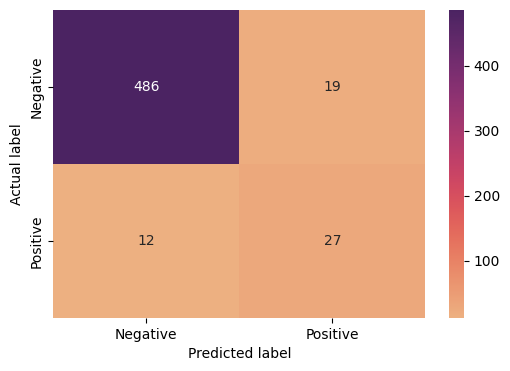

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='flare', fmt='d')
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()